# Hist 3368 - Week 12: Word Context Vectors w SKLearn

#### By Jo Guldi

#### From Word Vectors to Word Context Vectors

In previous notebooks, you've used word count vectors to compare the words most distinctive of companies and time periods, and to measure the abstract "distance" between different entities.

In our reading, we've learned that many scholars applied word vectors to understanding intellectual history. Word vectors can help you to understand the changing profile of every word -- how its "context" was different in 1920 than in 1980.  For example, the word "gay" meant "happy" in 1920, but by 1990 it had come to mean "homosexual."  Word context is the study of the changing words that surrounded "gay" in both instances.

Wordcount vectors can get you to changing word context. To perform such an investigation, you need to structure the data so that there is one vector for each word in every period of time.  This is called a “word context vector”. 

In this week's notebook, we'll make word context vectors for some words in Congress. We'll go through the following steps:
* First, we'll organize the data so that we have a dataframe of one word per row, where another column gives the sentence in which the word appears in Congress and the date.
* Then, we'll "groupby" keyword and period, so that we have an index for each keyword and period (for instance, "woman-1985") and a "context" column with every word next to which "woman" appears in the year 1985.
* Next, we'll use the word vector tools you already know -- SKLEARN's Countvectorizer(), .fit_transform -- to make vectors from this data.
* We'll use a measurement tool you already know -- cosine distance -- to compare context vectors for "woman" from 1985 to 1995 and 2005
* We'll use a comparison tool you already know -- vector subtraction -- to create a "gender difference vectors" whose low scores show words more likely to show up in the context of "woman" and whose high scores show words more likely to show up in the context of "man"
* Later in the notebook, we'll return to a 'word embedding' software package that uses high-dimensional math and hidden layers to make whip-fast vectors.


### Loading packages

In [2]:
import pandas as pd
import csv
import glob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import scipy.spatial.distance
import matplotlib
import matplotlib.pyplot as plt
import itertools
from nltk.tokenize import sent_tokenize
from nltk.tokenize.treebank import TreebankWordTokenizer

#### Load some Data

In [3]:
cd /scratch/group/history/hist_3368-jguldi

/scratch/group/history/hist_3368-jguldi


In [4]:
congress = pd.read_csv("congress1967-2010.csv")
all_data = congress.copy()
#congress = pd.read_csv("eighties_data.csv")

In [5]:
all_data[:5]

,Unnamed: 0,Unnamed: 0.1,speech,date,speaker,word_count,year,month,month_year
0,0,0,Those who do not enjoy the privilege of the fl...,1967-01-10,The VICE PRESIDENT,16,1967,1,1967-01-01
1,1,1,Mr. President. on the basis of an agreement re...,1967-01-10,Mr. MANSFIELD,35,1967,1,1967-01-01
2,2,2,The Members of the Senate have heard the remar...,1967-01-10,The VICE PRESIDENT,40,1967,1,1967-01-01
3,3,3,The Chair lays before the Senate the following...,1967-01-10,The VICE PRESIDENT,151,1967,1,1967-01-01
4,4,4,Secretary of State.,1967-01-10,Mrs. AGNES BAGGETT,3,1967,1,1967-01-01


In [6]:
all_data['5yrperiod'] = np.floor(all_data['year'] / 5) * 5 # round each year to the nearest 5 -- by dividing by 5 and "flooring" to the lowest integer
all_data = all_data.drop(['date', 'year', 'speaker','Unnamed: 0', 'Unnamed: 0.1', 'word_count', 'month'], 1)

In [7]:
all_data['index'] = np.arange(len(all_data)) # create an 'index' column

In [12]:
all_data.head()

,speech,month_year,5yrperiod,index
2432730,The bill is open to further amendment.,1980-08-01,1980.0,2432730
1880738,Is there objection?,1977-09-01,1975.0,1880738
4897211,I would like to call up my amendment.,1999-07-01,1995.0,4897211
2611724,We are grateful to the Senator.,1981-11-01,1980.0,2611724
2490181,Mr. Speaker. I believe the House needs to chan...,1980-12-01,1980.0,2490181


#### Downsample

In this exercise, the first pass, we're going to do some memory-intensive work on the computer by creating word context vectors 'by hand' -- i.e., using onyl SKLEARN's CountVectorizer() and .fit_transform + cosine distance and subtraction.  

Doing it this way is slower than loading some other packages that have been built specifically for working with large-scale wordcount vectors, where the code is packaged with high-dimensional math designed to make the comparisons run faster.

We're doing it this way, however, so that you can really see for yourself how a word vector is built and what's inside it at every moment.   

When we structure the data, build the vectors, subtract and measure the distance between vectors, we'll be able to inspect what's in the vector at every turn. You'd be able to do the math yourself if you looked more carefully.

Later in the notebook, we'll return to a 'word embedding' software package that uses high-dimensional math and hidden layers to make whip-fast vectors.

However, as we're doing old-fashioned vectors by hand, it'll go best if we "downsample" the data, taking a random sample of 5000 sentences spoken in Congress between 1985-2010.

Let's create some downsamples so we don't break the computer.

In [13]:
all_data_archive = all_data.copy()
sample_l = all_data.sample(500000)
sample_m = sample_l.sample(50000)
sample = sample_m.sample(5000)

ValueError: Cannot take a larger sample than population when 'replace=False'

Choose which data to work with here:

In [14]:
all_data = sample

### Structure the data

#### One word per row

We want to make a word context vector dataframe with one word per row.

Use str.split() and 

    .explode()

to create a dataframe with one word per row

In [52]:
clean_speech = pd.concat([all_data['speech'].str.lower().copy()])
clean_speech = clean_speech.str.replace('[^\w\s]','') # remove punctuation
clean_speech = clean_speech.str.replace('\d+', '') # for digits
clean_speech = clean_speech.str.strip() # strip the whitespace
clean_speech = clean_speech.str.replace(r'(\b\w{1}\b)', '') # for short words
word_per_row = clean_speech.str.split(' ').explode().reset_index() #explode the data 
word_per_row = word_per_row.rename({'speech' : 'keyword'}, axis = 1) # rename the column "sentence" to "keyword"
word_per_row

,index,keyword
0,2432730,the
1,2432730,bill
2,2432730,is
3,2432730,open
4,2432730,to
...,...,...
776882,1806759,incorporate
776883,1806759,the
776884,1806759,socalled
776885,1806759,ratchet


#### Minor Cleaning Steps

We only want one unique keyword-sentence combo for each line -- in case a keyword appears multiple times per one sentence.  

The following line gives us only unique keyword-speech pairs.  It uses "groupby" to find each unique keyword-index pair.

Notice that our data set is becoming smaller.

In [53]:
print(len(word_per_row))
word_per_row = word_per_row.groupby(['keyword','index']).size().reset_index().rename(columns={0:'count'})
print(len(word_per_row))

776887
354716


#### Get the context of each word per row

Merge the one-word data with the original congress dataframes to create a well-annotated dataframe of every word and its context.

In [67]:
word_context_words = pd.merge(word_per_row, all_data, on="index") # merge the two df's
word_context_words = word_context_words.drop('index', 1) # get rid of the index column because we don't need it any more
word_context_words

,keyword,count,speech,month_year,5yrperiod
0,,3,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
1,and,1,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
2,believe,1,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
3,body,1,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
4,chair,3,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
...,...,...,...,...,...
354711,to,1,To vote when?,1971-09-01,1970.0
354712,vote,1,To vote when?,1971-09-01,1970.0
354713,when,1,To vote when?,1971-09-01,1970.0
354714,when,1,When?,1996-02-01,1995.0


Let's strip the whitespace

In [68]:
word_context_words['keyword'] = word_context_words['keyword'].str.strip() # strip the whitespace
word_context_words

,keyword,count,speech,month_year,5yrperiod
0,,3,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
1,and,1,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
2,believe,1,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
3,body,1,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
4,chair,3,Mr. President. in a ruling that the motion of ...,1967-01-01,1965.0
...,...,...,...,...,...
354711,to,1,To vote when?,1971-09-01,1970.0
354712,vote,1,To vote when?,1971-09-01,1970.0
354713,when,1,To vote when?,1971-09-01,1970.0
354714,when,1,When?,1996-02-01,1995.0


Let's drop empty cells.

In [69]:
word_context_words['keyword'] = word_context_words['keyword'].str.strip() 
word_context_words = word_context_words[word_context_words['keyword'] != '']

## Format the data with one word per row -- and all its context in one cell

In [89]:
# format the data around our research into speakers
one_word_per_row = word_context_words.groupby('keyword').agg({'speech': ' '.join, 'count': 'sum'}).sort_values('count', ascending = False).reset_index()
one_word_per_row

,keyword,speech,count
0,the,Mr. President. in a ruling that the motion of ...,55312
1,of,Mr. President. in a ruling that the motion of ...,26915
2,to,Mr. Speaker. the 1968 budget shows once again ...,25868
3,and,Mr. President. in a ruling that the motion of ...,19871
4,in,Mr. President. in a ruling that the motion of ...,15789
...,...,...,...
26045,iteration,I thank our colleague from Nebraska for his th...,1
26046,ithaca,Mr. President. I rise today to speak about the...,1
26047,ithas,Mr. President. I point out that to my knowledg...,1
26048,ithe,Mr. President. I wish to take just 4 or 5 minu...,1


### Filter for Words of Interest

Most likely, we don't want to look at what's most distinctive of *all* words. We want to know about *certain* words. Let's make up a vocab.

In [90]:
vocab = ['woman', 'girl', 'lady', 'wife', 'bitch', 'queen', 'virgin', 'whore']

Let's look at just the word vectors for that vocab.

In [92]:
vocab_vectors = one_word_per_row[one_word_per_row['keyword'].isin(vocab)]
vocab_vectors

,keyword,speech,count
1528,wife,Mr. Speaker. I note with great happiness an ev...,53
1996,woman,Mr. Speaker. I note with great happiness an ev...,38
4089,virgin,Mr. President. on June 28. 1967. I mentioned o...,13
4171,lady,Mr. Speaker. I welcome this opportunity to joi...,13
8705,queen,It had nothing to do with our committee as I r...,4
10665,girl,Mr. Speaker. today I would like to recognize t...,3


#### Make Word Vectors -- One for Each Unit of Interest

In [93]:
# make a word vector and get some information from it
vectorizer = CountVectorizer(
    max_features=10000, 
    lowercase=True, 
    stop_words = 'english',
    ngram_range=(1, 2), 
    analyzer = "word",
    #tokenizer=LemmaTokenizer()
    )

vectorized = vectorizer.fit_transform(vocab_vectors['speech'])
vectorized

<6x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 17531 stored elements in Compressed Sparse Row format>

#### Make the Word Vectors Readable

In [95]:
all_words = np.array(vectorizer.get_feature_names())
keyword_names = list(vocab_vectors['keyword'].to_numpy())

vectors_dataframe = pd.DataFrame(vectorized.todense(), # the matrix we saw above is turned into a dataframe
                                 columns=all_words,
                                 index = keyword_names
                                 )
vectors_dataframe

,000,000 000,000 20,000 5percent,000 fee,000 finance,000 financing,000 fourfold,000 house,000 job,...,young old,young people,young seferino,young vincent,young woman,younger,younger person,youngsters,youth,youth differential
wife,37,0,0,0,1,0,0,0,0,0,...,0,0,1,1,1,1,1,0,2,0
woman,33,1,1,1,0,1,1,1,1,1,...,2,1,0,1,2,2,1,1,10,3
virgin,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lady,3,0,0,0,0,0,0,0,0,0,...,0,3,1,0,0,0,0,0,0,0
queen,22,1,1,1,0,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
girl,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


## Calculate Distinctiveness of Each Word w Log Likelihood 

#### Compute some baseline numbers about the data

In [98]:
keyword_context_total = vectors_dataframe.sum(axis=1)
word_totals = vectors_dataframe.sum(axis=0) 
total_corpus_words = sum(word_totals)

#### Measure distinctiveness with log likelihood

In [99]:
## create an empty dataframe
vocab_loglikelihood = []

## loop through every speaker in speaker_names
for vocab_id, vocab in enumerate(keyword_names):
    loglikely = []
    # loop through every word in the wordcount vector:
    for word_id in vectorized[vocab_id].indices:
        
        a = vectors_dataframe.iat[vocab_id, word_id] #  word in speaker
        b = word_totals[word_id] - a  # # word in remaining speakers
        c = keyword_context_total[vocab_id] - a #  not word in speaker
        d = total_corpus_words - a - b - c # not word in remaining speakers
       
        E1 = (a + c) * (a + b) / total_corpus_words  
        E2 = (b + d) * (a + b) / total_corpus_words 
        
        LL = 2 * (a * np.log(a / E1)) # the log likelihood equation
        if (b > 0):
            LL += 2 * b * np.log(b / E2)
        
        loglikely.append((LL, all_words[word_id])) # add the log likelihood score to the end of a new dataframe

    loglikely = sorted(loglikely, reverse=True) # the loop hits this every time it cycles through all the words in one speaker. 
    vocab_loglikelihood.append(loglikely) # add on another speaker


In [100]:
print("The 20 most distinctive words of each speaker. The words are listed from high to low ranking")
print("-------------------------------------------\n")
for i, speaker in enumerate(keyword_names):
    print(speaker + ": ", end='')
    distinct_words = [word[1] for word in vocab_loglikelihood[i][:20]]
    print(distinct_words)
    print("\n-----------------------------\n")

The 20 most distinctive words of each speaker. The words are listed from high to low ranking
-------------------------------------------

wife: ['travel office', 'office', 'travel', 'dale', 'billion', 'billy', 'percent', 'billy dale', 'fbi', 'white house', 'white', 'fees', 'indictment', 'increase', 'prosecution', 'employees', 'investigation', 'soviet', 'house', 'checks']

-----------------------------

woman: ['navy', 'rotc', 'navy rotc', 'travel', 'woman', 'office', 'increase', 'fbi', 'white house', 'white', 'health', 'fees', 'wife', 'scholarships', 'taxes', 'abortion', 'pregnancy', 'deficit', 'percent', 'disability']

-----------------------------

virgin: ['native', 'virgin', 'native americans', 'islands', 'americans', 'virgin islands', 'native american', 'contributions', 'history', 'recycling', 'war', 'heritage day', 'american heritage', 'society', 'heritage', 'american', 'day', 'article', 'significant contributions', 'res 40']

-----------------------------

lady: ['unemployment',

## Visualizing the distinctiveness of the language of each speaker

Note that we're going to make a big plot.

***This might take a minute or two to run.***

In [ ]:
cd ~/digital-history

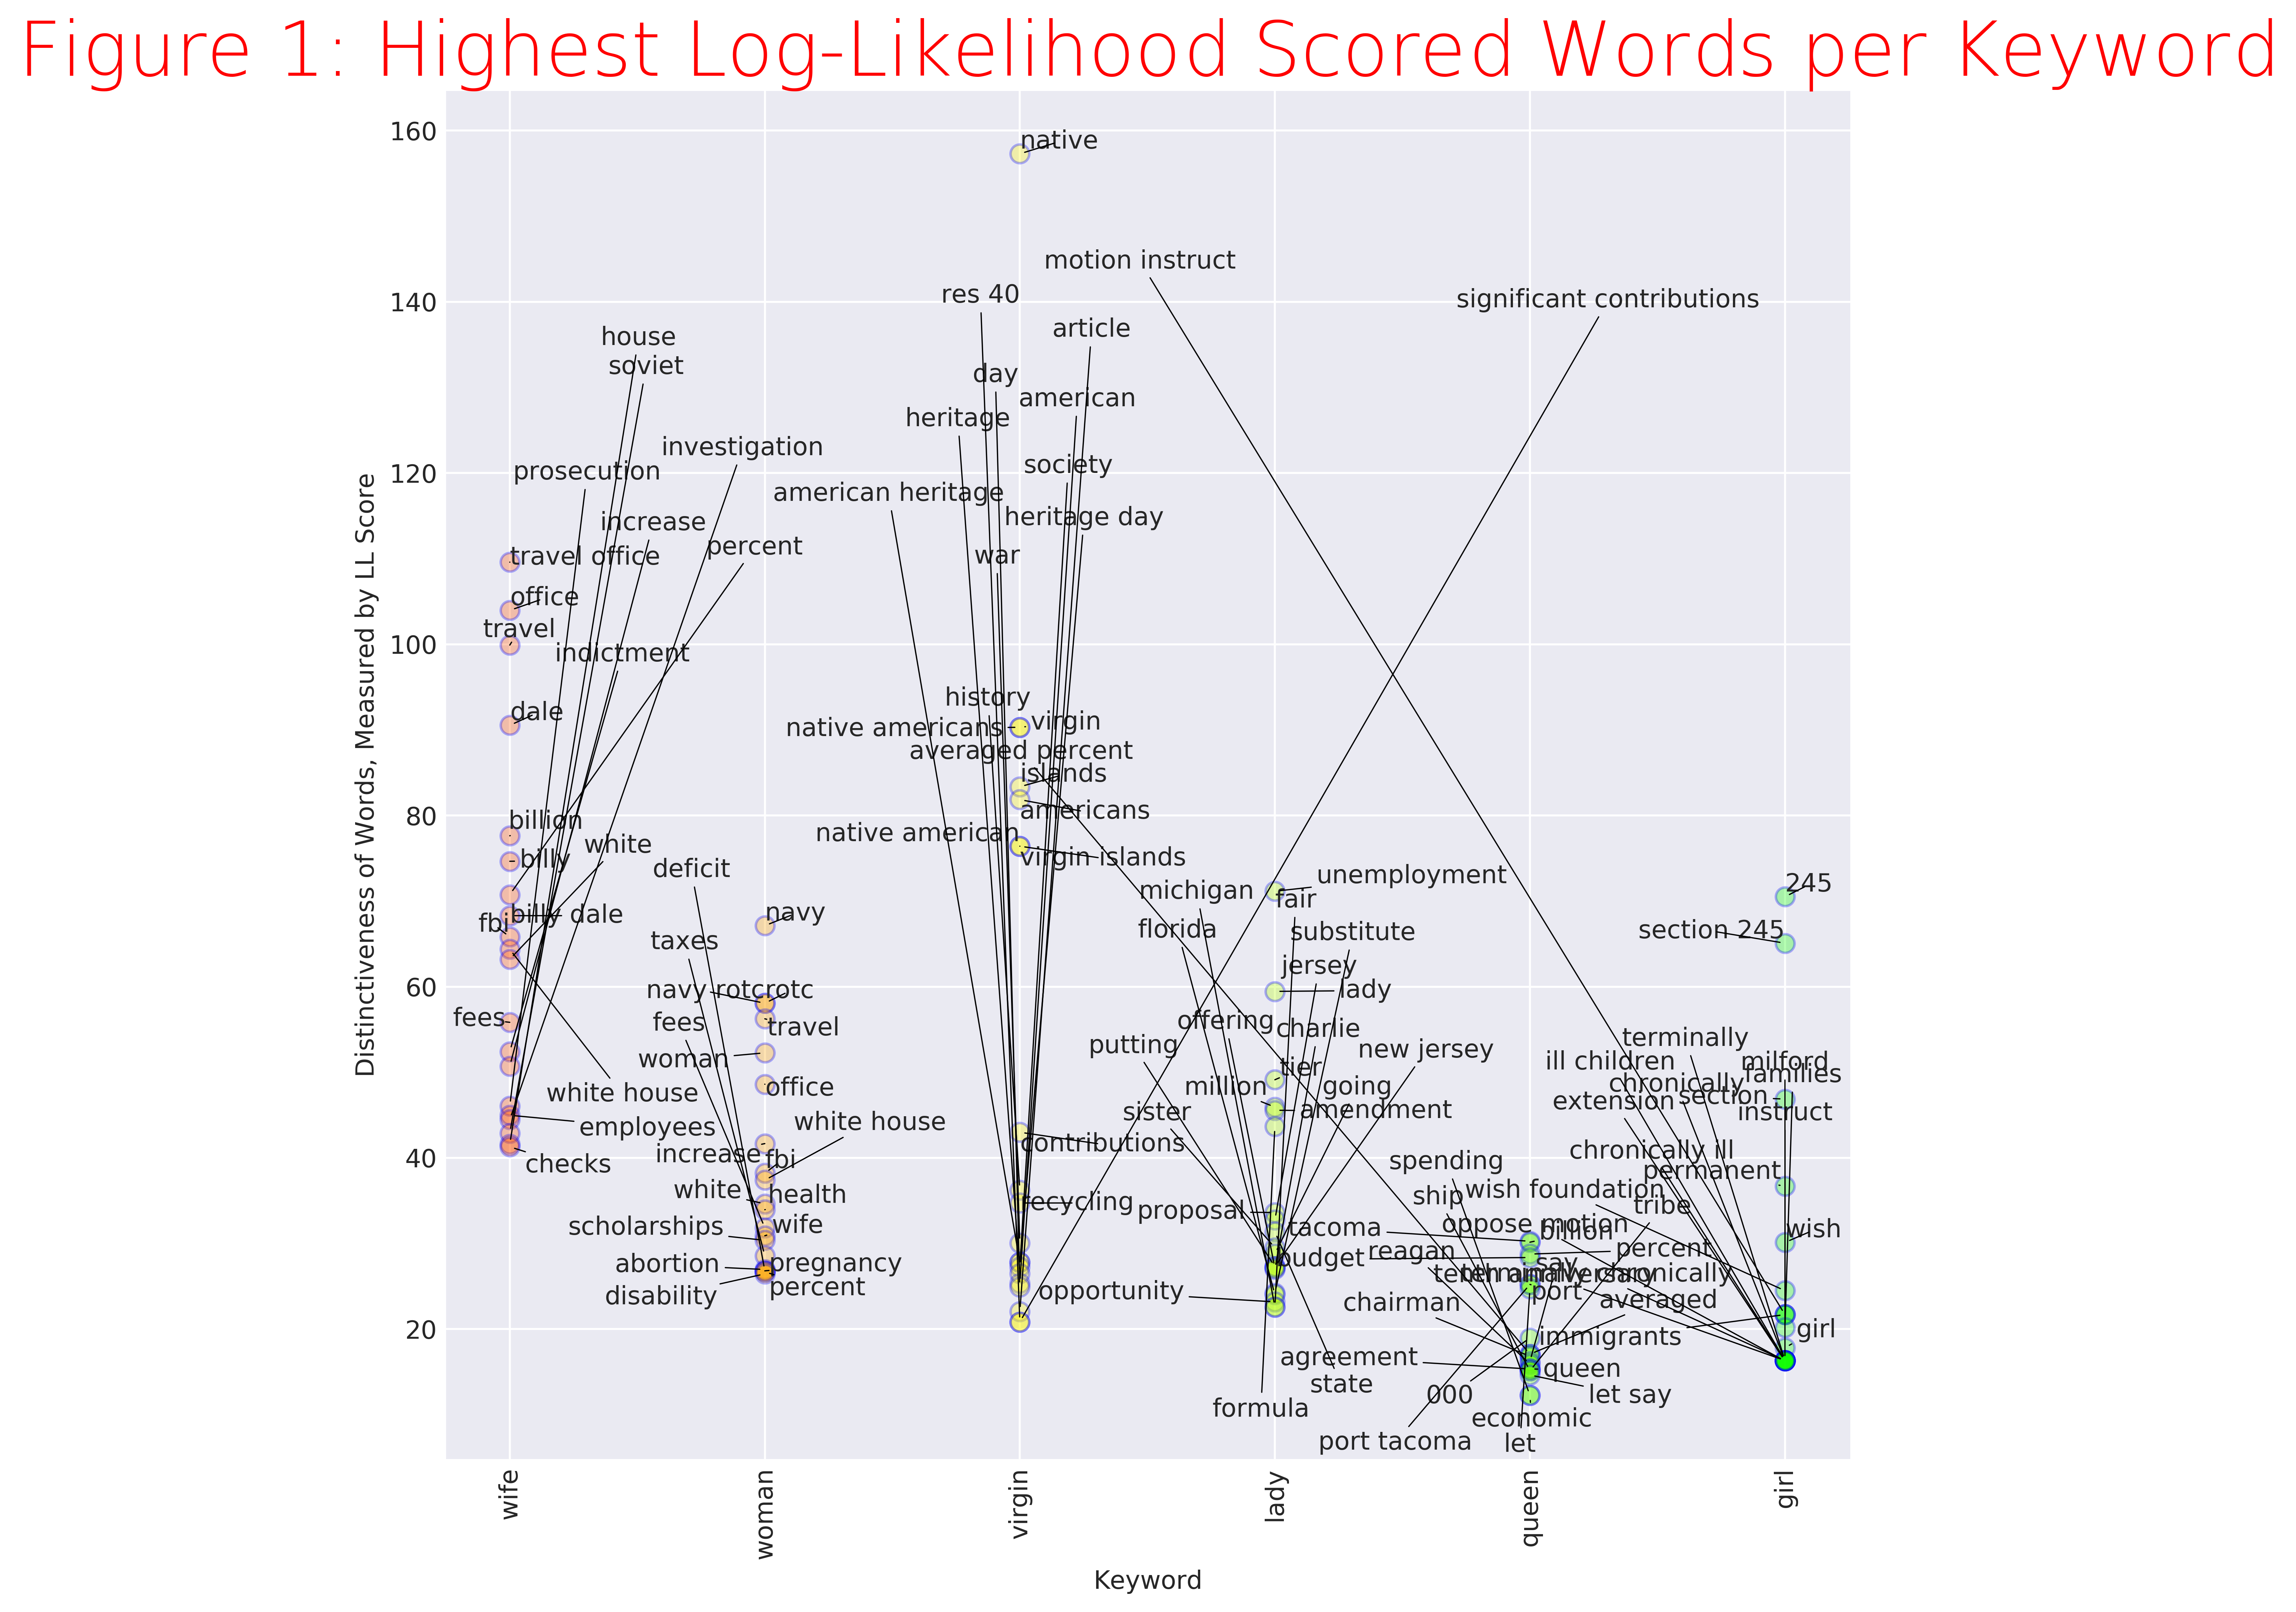

<Figure size 432x288 with 0 Axes>

In [101]:
%matplotlib inline
from adjustText import adjust_text

# change the figure's size here
plt.figure(figsize=(10,10), dpi = 500)

# style
plt.style.use('seaborn-darkgrid') # this gives us a grid with a dark background.  you can play with this to change the style.
  
# create a color palette
palette = plt.get_cmap('hsv') # this tells matplotlib what colors to use.  you can play with this to change the colors.

# start a counter at 0
num = 0

# create an empty list
texts = []

# this is the for loop that creates multiple plots.  
for i, vocab in enumerate(keyword_names):
        num += 14 # num tells the plot to choose a different color for each speaker
        distinct_words = vocab_loglikelihood[i][:20] # plot the top twenty words by LL-score
        for word in distinct_words: # for each word-per-speaker instance, plot the ll_score on the y axis
            ll_score = word[0] # find just the ll-score from speakers_loglikelihood
            word_label = word[1] # find just the keyword name from speakers_loglikelihood
            plt.scatter( # draw a dot for each word
                    vocab, # with speaker on the x axis
                    ll_score, # and ll_score on the y axis
                    color=palette(num), # using a different color for each speaker
                    linewidth=1, 
                    edgecolors = 'b',
                    s = 55, # size
                    alpha=0.3, # make the dots slightly transparent
                    label=vocab) # label each dot with the name of the word
            texts.append(plt.text(vocab, ll_score, word_label)) # save these coordinates to be used in labeling

# Add legend
plt.xticks(rotation=90)
 
# Add titles
plt.title("Figure 1: Highest Log-Likelihood Scored Words per Keyword", fontsize=30, fontweight=0, color='Red')
plt.xlabel("Keyword")
plt.ylabel("Distinctiveness of Words, Measured by LL Score")

# Code to help with overlapping labels -- may take a minute to run
adjust_text(texts, force_points=0.2, force_text=0.2,
            expand_points=(1, 1), expand_text=(1, 1),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# save it
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('LL-fig1.jpg', dpi=500)

## Measure with all the words

In the above example, we tested the log likelihood of certain keywords.

Sometimes, however, we want to measure the *distance* between the word context vector for one word and the word context vector for another word.


Instead of filtering for a controlled vocabulary, let's take the word context vectors for the whole sample.

Let's look at just the word vectors for that vocab.

In [103]:
vocab_vectors = one_word_per_row
vocab_vectors

,keyword,speech,count
0,the,Mr. President. in a ruling that the motion of ...,55312
1,of,Mr. President. in a ruling that the motion of ...,26915
2,to,Mr. Speaker. the 1968 budget shows once again ...,25868
3,and,Mr. President. in a ruling that the motion of ...,19871
4,in,Mr. President. in a ruling that the motion of ...,15789
...,...,...,...
26045,iteration,I thank our colleague from Nebraska for his th...,1
26046,ithaca,Mr. President. I rise today to speak about the...,1
26047,ithas,Mr. President. I point out that to my knowledg...,1
26048,ithe,Mr. President. I wish to take just 4 or 5 minu...,1


#### Make Word Vectors -- One for Each Unit of Interest

In [104]:
# make a word vector and get some information from it
vectorizer = CountVectorizer(
    max_features=10000, 
    lowercase=True, 
    stop_words = 'english',
    ngram_range=(1, 2), 
    analyzer = "word",
    #tokenizer=LemmaTokenizer()
    )

vectorized = vectorizer.fit_transform(vocab_vectors['speech'])
vectorized

<26050x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 27508685 stored elements in Compressed Sparse Row format>

#### Make the Word Vectors Readable

In [106]:
all_words = np.array(vectorizer.get_feature_names())
keyword_names = list(vocab_vectors['keyword'].to_numpy())

vectors_dataframe = pd.DataFrame(vectorized.todense(), # the matrix we saw above is turned into a dataframe
                                 columns=all_words,
                                 index = keyword_names
                                 )
vectors_dataframe[:5]

,000,000 000,000 acres,000 applications,000 cases,000 employees,000 enrollment,000 filipino,000 house,000 jobs,...,younger,youngsters,youth,youth alliance,youths,yugoslavia,zero,zone,zones,zoning
the,714,31,11,3,6,4,7,4,5,17,...,11,12,65,9,7,37,17,9,10,4
of,706,31,11,3,6,4,7,4,5,17,...,11,12,65,9,7,37,15,9,10,4
to,692,23,11,3,6,4,7,4,5,17,...,11,12,65,9,7,37,18,9,10,4
and,698,28,11,3,6,4,7,4,5,15,...,11,12,64,9,7,37,18,9,10,4
in,696,24,11,3,6,4,7,4,5,17,...,11,12,64,9,7,37,15,9,10,4


### Taking measurements of vectors

In our last exercise, we measured how different individual words were from each other.

Let's do it again.

In [111]:
woman_vector = vectors_dataframe.filter(regex = ('\\bwoman\\b'), axis=0) # the caret (^) means 'begins with'
woman_vector

,000,000 000,000 acres,000 applications,000 cases,000 employees,000 enrollment,000 filipino,000 house,000 jobs,...,younger,youngsters,youth,youth alliance,youths,yugoslavia,zero,zone,zones,zoning
woman,33,1,1,0,0,0,0,0,1,0,...,2,1,10,0,0,0,0,0,0,0


In [112]:
lady_vector = vectors_dataframe.filter(regex = ('\\blady\\b'), axis=0) # the caret (^) means 'begins with'
lady_vector

,000,000 000,000 acres,000 applications,000 cases,000 employees,000 enrollment,000 filipino,000 house,000 jobs,...,younger,youngsters,youth,youth alliance,youths,yugoslavia,zero,zone,zones,zoning
lady,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The vectors_dataframe is nice to use because its rows and columns are nicely labeled.  It's easy to call exactly the keyword-period combination you want.  

You can use the rows directly pulled from vectors_dataframe as the basis for calculating cosine distances.

In [113]:
scipy.spatial.distance.cosine(woman_vector, lady_vector)

0.4702260955445603

#### Subtracting vectors

Above, we called the rows of vectors_dataframe directly to calculate cosine distances.  

We can use these same vectors to execute a subtraction -- with a bit of reformatting.

First, we "transmute" them from a horizontal row of values to a vertical row of values with 

    .T


Next, we call the columns with the values by name, e.g.: 

    ['woman-1985.0']


In [115]:
diff = woman_vector.T['woman'] - lady_vector.T['lady']
diff

000                 30
000 000              1
000 acres            1
000 applications     0
000 cases            0
                    ..
yugoslavia           0
zero                 0
zone                 0
zones                0
zoning               0
Length: 10000, dtype: int64

We "sort" the values from small to big using:

    .sort_values()



In [116]:
diff.sort_values()

lady           -13
unemployment   -12
charlie        -10
tier            -9
proposal        -9
                ..
navy            48
year            51
percent         56
mr              62
people          77
Length: 10000, dtype: int64

Hint: use 
    
    .dropna() 
    
to get rid of NaN's (not a number)

In [117]:
diff.dropna().sort_values()

lady           -13
unemployment   -12
charlie        -10
tier            -9
proposal        -9
                ..
navy            48
year            51
percent         56
mr              62
people          77
Length: 10000, dtype: int64

Here are the words most characteristic of 'lady' but not 'woman':

In [119]:
diff.nlargest(10)

people      77
mr          62
percent     56
year        51
navy        48
billion     44
health      40
increase    40
care        39
say         39
dtype: int64

Here are the words most characteristic of 'woman' but not 'lady':

In [122]:
diff.nsmallest(10)

lady           -13
unemployment   -12
charlie        -10
proposal        -9
tier            -9
amendment       -8
formula         -8
jersey          -6
offering        -6
opportunity     -6
dtype: int64

## Compare words used for 'man' and 'woman'

Let's make a vector that contains all the references to women.

In [124]:
pattern = ['woman','women','\bshe','\bher','\bhers','girl']
woman_vector = vectors_dataframe.loc[[x for x in vectors_dataframe.index for word in pattern if word in x]]

woman_vector[:15]

,000,000 000,000 acres,000 applications,000 cases,000 employees,000 enrollment,000 filipino,000 house,000 jobs,...,younger,youngsters,youth,youth alliance,youths,yugoslavia,zero,zone,zones,zoning
women,88,2,1,0,2,0,0,0,0,1,...,1,2,17,0,2,1,1,0,1,0
gentlewoman,24,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
woman,33,1,1,0,0,0,0,0,1,0,...,2,1,10,0,0,0,0,0,0,0
womens,8,0,0,1,1,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0
girls,0,0,0,0,0,0,0,0,0,0,...,0,0,9,0,3,0,0,0,0,0
congresswoman,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
womans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chairwoman,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
businesswomen,10,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
gentlewomans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


That's the data we want, all right. But it'd be more useful as a matrix where all the columns are added together. 

That's easy to do with 

    .sum()

In [125]:
woman_vector = woman_vector.sum()
woman_vector

000                 169
000 000               4
000 acres             4
000 applications      2
000 cases             4
                   ... 
yugoslavia            1
zero                  1
zone                  0
zones                 4
zoning                0
Length: 10000, dtype: int64

Perfect! Now let's look for men

In [126]:
import re
pattern2 = ['\bhe\b','\bhim','\bhis','\bman\b','\bmen\b','boy\b','boys']
man_vector = vectors_dataframe.loc[[x for x in vectors_dataframe.index for word in pattern2 if word in x]]
man_vector = man_vector.sum()
man_vector

000                 2
000 000             0
000 acres           0
000 applications    0
000 cases           0
                   ..
yugoslavia          0
zero                0
zone                0
zones               0
zoning              0
Length: 10000, dtype: int64

In [127]:
gender_diff_vector = man_vector - woman_vector

In [128]:
gender_diff_vector.sort_values()

mr           -499
people       -410
president    -284
women        -271
speaker      -260
             ... 
meat           13
boy scouts     18
boy            18
boys           18
scouts         22
Length: 10000, dtype: int64

The output of gender_diff_vector.sort_values() is predictive of the words most likely to refer to women (the negatives) and the words most likely to indicate men (the higher positives.)

Here are the words most characteristic of talking about men but not women:

In [132]:
gender_diff_vector.nlargest(20)

scouts                 22
boy                    18
boy scouts             18
boys                   18
meat                   13
catholic               12
everett                10
scouts america          9
catholic university     7
heritage                7
heritage center         7
luncheon                7
regards                 7
dangelo                 6
bailout                 5
intervention            5
south vietnam           5
inspection              4
jordan                  4
laos                    4
dtype: int64

Here are the words most characteristic of talking about women but not men:

In [131]:
gender_diff_vector.nsmallest(20)

mr           -499
people       -410
president    -284
women        -271
speaker      -260
time         -249
mr speaker   -240
health       -235
percent      -233
going        -231
year         -226
years        -226
states       -223
congress     -219
country      -218
just         -211
want         -210
american     -203
today        -201
amendment    -195
dtype: int64